# Protecting the Past: Predicting Archaeological Site Locations in Northern Mesopotamia
Starting in 2012, archaeologists flooded into Iraqi Kurdistan.  Political unrest had made the area unstable for archaeological work for many years, but new-found wealth and security in the region made it possible to work in Iraqi Kurdistan again.  This widespread optimism continued through 2014, with [an entire day and plenary address](http://www.asor.org/am/2014/_baks/plenary.html.0014.b5ff.bak) devoted to the archaeology of Northern Mesopotamia at the 2014 American School of Oriental Research conference.  In two years, archaeologists had identified more sites per square kilometer than in any other surrounding region ([Ur, et al. 2013: 119](https://dash.harvard.edu/bitstream/handle/1/11510264/Ur%20etal%202013%20EPAS%20Iraq.pdf?sequence=1)).  The thousands of years of unstudied cultural artifacts and unexcavated ancient cities promised to overturn and refine our conceptions about everything from the rise of civilization to the long history of urbanism in the region. Furthermore, lawful excavations can promote regional pride and enhance tourism via museums showcasing the wonders of Northern Iraq: the famous Shanidar cave Neanderthal burial, the core of the Assyrian Empire, and the rise and fall of settlements up through the present day.

However, in June of 2014, the terrorist group ISIS emerged and tarnished much of the initial optimism for the region. In addition to promoting widespread killings around the world, the group has destroyed archaeological sites and killed archaeologists in its territory (for instance the widely circulated videos at [the Mosul museum](http://www.theguardian.com/world/2015/feb/26/isis-fighters-destroy-ancient-artefacts-mosul-museum-iraq) and the [city of Palmyra](http://www.bbc.com/news/world-middle-east-33984006)).  While the Kurdish Regional Government has been able to hold its borders with the help of global allies, large portions of Northern Iraq and Syria remain contested or fully within ISIS control.  Archaeological sites continue to be threatened throughout the region.  While foreign archaeologists have withdrawn from the region, a small number of local archaeologists remain, documenting what they can of the sites available to them.  

The act of finding archaeological sites to document can be very difficult, however.  Sites in Mesopotamia are mounds of condensed earth that have been packed together in the process of building and rebuilding mudbrick houses in the same location over thousands of years.  Tall and expansive mounds are correlated with long term, large scale settlement.  Short and tiny mounts are correlated with short term, more ephemeral settlement (but still often extremely important!). On the ground, small sites are often indistinguishable from small hills and agricultural work obscures their characteristic signature on the ground.  For instance, see this small site area:
<img src=Images/small_site.JPG/>
And compare it with a larger, more obvious site:
<img src=Images/obvious_site.JPG/>

With the abundance of different satellites and radar images, it has become possible to predict the location of potential archeological sites using data science. Indeed, through classification methods and by using the data of some already know site locations, potential site locations can now be predicted, opening whole new opportunities for archeologists.  These have mixed success.  For instance, a fully automated Random Forest classifier yielded only 85/133 test accuracy for Menze et al. using 90m resolution SRTM elevation data [(2005)](http://hci.iwr.uni-heidelberg.de/publications/mip/techrep/menze_05_tell.pdf).  The addition of multispectral satellite image data improved Menze and Ur's accuracy [(2012)](http://www.pnas.org/content/109/14/E778), but required manually checking sites via high resolution imagery in order to reach their reported ~95% accuracy for some regions.  Through this semiautomated process of classifying and then manually checking Northeastern Syria, they identified over 14,000 sites in the region.  However, because the process is only semi-automated, they did not produce a reproducible solution that can be easily transferable to other regions, such as Northern Iraq.

Thus, in order to help local archaeologists make efficient use of their time given the continuing ISIS threat, we produced a classifier that predicts archaeological site locations based on freely available satellite imagery (SRTM, Landsat, and Corona).  With these locations identified, we give local authorities a fighting chance at protecting these sites, and archaeologists the opportunity to study them.  While large scale archaeological survey in Northern Iraq remains incomplete, the adjacent region in Northeastern Syria remotely surveyed by Menze and Ur features a large corpus of site location data that is available freely online.  Therefore, we trained and validated our classifier in Northeastern Syria using Menze and Ur's site location data before making predictions from satellite images of Northern Iraq.  In addition, we made our data download and wrangling routines as programmatic as possible in order to ensure ready reproducibility for future researchers using our approach in other regions.

# Table of contents

### A- Data scraping, merging and wrangling

   [1. Loading SRTM Images](#1.-Loading-SRTM-Images) 
   
   [2. Loading Landsat 8 Images](#2.-Loading-LandSat8-Images) 
   
   [3. Loading Corona Images](#3.-Loading-Corona-Images) 
   
   [4. Merge the image files together](#4.-Merge-the image-files-together) 
   
   [5. Reprojecting SRTM and Landsat Images](#5.-Reprojecting-SRTM-and-LandSat-Images)
   
   [6. Clip Rasters to Data Region](#6.-Clip-Rasters-to-Data-Region)
   
   [7. Principal Component Analysis](#Principal-Component-Analysis)
   
   [8. Thresholding to transform the images to binary matrices](#8.-Thresholding-to-transform-the-images-to binary-matrices)
   

### B- Response Variable Wrangling

### C- Classification processes 
   

# A- Data scraping, merging and wrangling

In [4]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import os
import matplotlib.pyplot as plt
import gdal
from rasterstats import zonal_stats
from sklearn.decomposition import PCA
import pickle
from osgeo import gdal
from osgeo import osr
import csv

In [3]:
import wget
import time
import json

As a first step, the different image types were loaded into iPython in order to be transformed 
into numpy arrays that could be used for classification purposes of the archeological sites: The Shuttle radar topography mission (or SRTM) images provide information about settlements and elevation of the soil. The Landsat8 images provide information about the moisture content of the soil: It is the images produced by a satellite that images the entire earth surface every 16 days, hence providing very up to date information. The Corona images  (the first generation of U.S. photo intelligence satellites conatining more than 860,000 images of the earth surface between 1960 and 1972) provide a very detailed resolution of the surface of the earth taken by aerial photographs.

## 1. Loading SRTM Images

The STRM images are scraped from their website: http://droppr.org
The Shuttle Radar Topography Mission (SRTM), is a NASA project recording elevation data over the entire globe. Researchers gather the elevation data from estimations of radar interference made by antennas onboard a space shuttle made by antennas onboard a space shuttle. All of this data is available free of charge from the USGS. We downloaded from a USGS mirror for the version 4.1 SRTM data, that has no missing values and is projected to WGS84. In many areas of the world, 30m SRTM resolution is now available, however, in the Middle East, the best available resolution is still 90m.

Loading the SRTM image would take around an hour: In order to avoid repeating this process, we have stored the data to a csv file and numpy arrays that can easily be loaded. 
The scraping of the images corresponds to the following cell and should be commented out to avoid long running times.

In [8]:
#Download from USGS mirror
link='http://droppr.org/srtm/v4.1/6_5x5_TIFs/'

#For image region, download all zipped tif files, unzip into the current directory, then remove the zipped files:
for i in [44,45]: 
    for j in [5,6]:
        wget.download('http://droppr.org/srtm/v4.1/6_5x5_TIFs/srtm_%s_0%s.zip'%(i,j))  

In [48]:
import zipfile
for i in [44,45]: 
    for j in [5,6]:
        zip = zipfile.ZipFile('srtm_%s_0%s.zip' %(i,j))
        zip.extractall()

## 2. Loading LandSat8 Images

Landsat images are multispectral satellite images that record everything from visible light to infrared and thermal observations, covering the entire the earth every 16 days. In total, each Landsat image is composed of 12 bands of information, with each band downloadable as an image (all around 500MB). Because these bands each include different types of information, when they are combined, they have the ability to explain a lot about a region when training a classifier. Bands 1-7 and 9-12 are 30m resolution and Band 8 is 15m resolution. The Landsat program has been active for over 40 years and is one of the most widely used sources of imagery for geographically-oriented academic work. It is also made freely available online by the USGS. We used the landsat-util command line tool to search for images over Northeast Syria (in Landsat terms, this is Path 171, Row 34-35) that included the least cloud cover (i.e. exposed the most land and were most useable for searching ground features) and only downloaded these images for our dataset.

In [14]:
!echo $SHELL

/bin/bash


In [15]:
list_images = !landsat search --cloud 4  -p 171,035
image = []
clouds = []
htmls = []
LCs = []
for i in xrange(len(np.str(list_images).split("{',"))-2):
    image.append(np.str(list_images).split("{',")[i+2])
    clouds.append(np.float((image[i].split("cloud")[1]).split(",")[0].split(": ")[1]))
    htmls.append("http"+image[i].split("http")[1].split(",")[0][:-2])
    LCs.append(image[i].split("sceneID")[1].split(",")[0][4:-1])

smallest_cloud = np.str(LCs[np.argmin(clouds)])
second_smallest = np.str(LCs[np.argsort(clouds)[1]])
print smallest_cloud, second_smallest

LC81710352015234LGN00 LC81710352015138LGN00


In [12]:
LCs[np.argsort(clouds)[1]]

'LC81710352015138LGN00'

In [16]:
!landsat download LC81710352015234LGN00 --bands 123

===> Downloading: LC81710352015234LGN00_B4.TIF
     LC81710352015234LGN00_B4.TIF already exists on your system
===> Downloading: LC81710352015234LGN00_B3.TIF
     LC81710352015234LGN00_B3.TIF already exists on your system
===> Downloading: LC81710352015234LGN00_B2.TIF
     LC81710352015234LGN00_B2.TIF already exists on your system
===> Downloading: LC81710352015234LGN00_BQA.TIF
     LC81710352015234LGN00_BQA.TIF already exists on your system
===> Downloading: LC81710352015234LGN00_MTL.txt
     LC81710352015234LGN00_MTL.txt already exists on your system
===> Download Completed
===> Done!
Time spent : 2.49 seconds


In [13]:
!landsat download LC81710352015234LGN00 --bands 456

===> Downloading: LC81710352015234LGN00_B6.TIF
   100%     64.0 MiB     442.8 KiB/s            0:00:00 ETA    
     stored at /Users/macuser/landsat/downloads/LC81710352015234LGN00
===> Downloading: LC81710352015234LGN00_B7.TIF

     stored at /Users/macuser/landsat/downloads/LC81710352015234LGN00
===> Downloading: LC81710352015234LGN00_B8.TIF
   100%    247.1 MiB     550.0 KiB/s            0:00:00 ETA    
     stored at /Users/macuser/landsat/downloads/LC81710352015234LGN00
===> Downloading: LC81710352015234LGN00_BQA.TIF
     LC81710352015234LGN00_BQA.TIF already exists on your system
===> Downloading: LC81710352015234LGN00_MTL.txt
     LC81710352015234LGN00_MTL.txt already exists on your system
===> Download Completed
===> Done!
Time spent : 717.58 seconds


In [14]:
!landsat download LC81710352015234LGN00 --bands 789

===> Downloading: LC81710352015234LGN00_B9.TIF
   100%     37.5 MiB     490.7 KiB/s            0:00:00 ETA    
     stored at /Users/macuser/landsat/downloads/LC81710352015234LGN00
===> Downloading: LC81710352015234LGN00_B10.TIF
   100%     46.4 MiB     595.4 KiB/s            0:00:00 ETA    
     stored at /Users/macuser/landsat/downloads/LC81710352015234LGN00
===> Downloading: LC81710352015234LGN00_B11.TIF
   100%     43.9 MiB     515.2 KiB/s            0:00:00 ETA    
     stored at /Users/macuser/landsat/downloads/LC81710352015234LGN00
===> Downloading: LC81710352015234LGN00_BQA.TIF
     LC81710352015234LGN00_BQA.TIF already exists on your system
===> Downloading: LC81710352015234LGN00_MTL.txt
     LC81710352015234LGN00_MTL.txt already exists on your system
===> Download Completed
===> Done!
Time spent : 246.26 seconds


In [18]:
!landsat download LC81710352015234LGN00 --bands 1011

===> Downloading: LC81710352015234LGN00_B1.TIF
   100%     58.1 MiB     584.9 KiB/s            0:00:00 ETA    
     stored at /Users/macuser/landsat/downloads/LC81710352015234LGN00
===> Downloading: LC81710352015234LGN00_BQA.TIF
     LC81710352015234LGN00_BQA.TIF already exists on your system
===> Downloading: LC81710352015234LGN00_MTL.txt
     LC81710352015234LGN00_MTL.txt already exists on your system
===> Download Completed
===> Done!
Time spent : 102.75 seconds


In [23]:
image = []
clouds = []
htmls = []
LCs = []
for i in xrange(len(np.str(list_images).split("{',"))-2):
    image.append(np.str(list_images).split("{',")[i+2])
    clouds.append(np.float((image[i].split("cloud")[1]).split(",")[0].split(": ")[1]))
    htmls.append("http"+image[i].split("http")[1].split(",")[0][:-2])
    LCs.append(image[i].split("sceneID")[1].split(",")[0][4:-1])

smallest_cloud = np.str(LCs[np.argmin(clouds)])
second_smallest = np.str(LCs[np.argsort(clouds)[1]])
print smallest_cloud, second_smallest

LC81710342013228LGN00


In [36]:
!landsat download LC81710342013228LGN00 --bands 123

===> Downloading: LC81710342013228LGN00.tar.bz
     LC81710342013228LGN00.tar.bz already exists on your system
===> Download Completed
===> Done!
Time spent : 0.41 seconds


In [ ]:
!landsat download LC81710342013228LGN00 --bands 456

In [ ]:
!landsat download LC81710342013228LGN00 --bands 789

In [35]:
!landsat download LC81710342013228LGN00 --bands 1011

===> Downloading: LC81710342013228LGN00.tar.bz
     LC81710342013228LGN00.tar.bz already exists on your system
===> Download Completed
===> Done!
Time spent : 0.77 seconds


In [5]:
## NEED TO UNZIP THE LANDSAT IMAGES: TAR.BZ
import tarfile
tarfile.open(name='/Users/macuser/landsat/downloads/LC81710342013228LGN00.tar.bz')

## 3. Loading Corona Images

CORONA images are [declassified spy satellite images taken in the late 1960s](http://scholar.harvard.edu/jasonur/pages/corona-photography-1) at a high resolution (2m).  CORONA images not only give researchers the ability to identify features at a high resolution, they also present us with past landscapes that have disappeared since the 1960s.  Cities such as Erbil and Mosul in Northern Iraq have exploded in size since this time and have covered many archaeological sites that were visible in the 1960s.  Therefore, including this image type is very useful for identifying features of archaeological sites that might only have been visible in the past.  Here, we use images over Northeast Syria from mission 1102-1025 from Dec 11, 1967.

We downloaded our CORONA images from the University of Arkansas' "Corona Atlas of the Middle East" (taking those that covered our area of interest) and reprojected them to UTM Zone 37N.  Then, we extrapolated the data to 30m resolution so that we matched the Landsat resolution.  Future research should include testing how well finer resolutions work in classification.  For our purposes, we stayed at a 30m resolution so as to minimize file size (30m resolution is still 500MB!), but with more time and computational power, we could increase resolution to see how much of an impact this has.  In order to perform reprojections and interpolation, we used the gdal library and its accompanying command line utilities (in particular [gdalwarp](http://www.gdal.org/gdalwarp.html), here).  These are standards in the open source geographic research community.

In [ ]:
#First, install gdal in order to run gdalwarp and gdalmerge.py:
!pip install gdal

In [28]:
#Download Corona aerial photographs from University of Arkansas' collection from 3-9
for i in xrange(3,10):
    url = 'http://cast-ftp1.cast.uark.edu/coronaftp/1102-1025d/1102-1025df/ds1102-1025df00%d.ntf' % (i)
    wget.download(url)

In [3]:
%%bash

for i in {3..9};
  do
    gdalwarp -t_srs epsg:32637 ds1102-1025df00$i.ntf out$i.tif;
  done

Creating output file that is 107485P x 26219L.
Processing input file ds1102-1025df003.ntf.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 107451P x 26184L.
Processing input file ds1102-1025df004.ntf.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 107434P x 26199L.
Processing input file ds1102-1025df005.ntf.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 107424P x 26215L.
Processing input file ds1102-1025df006.ntf.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 107428P x 26203L.
Processing input file ds1102-1025df007.ntf.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 107411P x 26232L.
Processing input file ds1102-1025df008.ntf.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 107432P x 26256L.
Processing input file ds1102-1025df009.nt

In [4]:
!gdalbuildvrt -srcnodata 0 corona_merged.vrt out3.tif out4.tif out5.tif out6.tif out7.tif out8.tif out9.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


Increase resolution from 2m to 30m resolution using Nearest Neighbor Interpolation (gdalwarp's default) and merge images together:

In [5]:
!gdalwarp -srcnodata 0 -dstalpha -tr 30 30 corona_merged.vrt corona_merged.tif

Creating output file that is 8503P x 4832L.
Processing input file corona_merged.vrt.
Copying nodata values from source corona_merged.vrt to destination corona_merged.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


## 4. Merge the image files together (Merge the Rasters)

We have loaded several images of each type to cover the area we are studying. In order to have one matrix per image type (one for the Corona, one for the Landsat, and one for the SRTM images), we merge the different rasters into a continuous geographic area.
In order to do that, we use gdal_merge.py from gdal library.
(see http://www.gdal.org/gdal_merge.html for more information)

### SRTM Images:

In [5]:
%%bash
gdal_merge.py -o srtm_complete.tif srtm_44_05.tif srtm_44_06.tif srtm_45_05.tif srtm_45_06.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


### Landsat Images:
For the Landsat Images, we start by removing the no-data entries in order to avoid image frame overlap and then merge together each band type (1 to 11).  We don't use band 12 (QA Band) here because this is primarily meant as a quality assurance band that is often used by researchers wishing to separate particular environmental features in the other bands.  Once we better understand which bands and band magnitudes matter for archaeological site prediction, we may be able to make better use of this band.

In [9]:
%%bash
#assuming all files are in the same directory, use virtual dataset to lazily evalute as in here (http://www.perrygeo.com/lazy-raster-processing-with-gdal-vrts.html):
for i in {1..11};
  do
    gdalbuildvrt -srcnodata 0 lc_merged_B$i.vrt LC*B$i.TIF;
  done

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


#### Write each merged file to a TIF file 

In [10]:
%%bash
#Write each merged set of files to a TIF
for i in {1..11};
  do
    gdalwarp -srcnodata 0 -dstalpha lc_merged_B$i.vrt lc_merged_B$i.TIF
  done

Creating output file that is 8651P x 13061L.
Processing input file lc_merged_B1.vrt.
Copying nodata values from source lc_merged_B1.vrt to destination lc_merged_B1.TIF.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 8651P x 13061L.
Processing input file lc_merged_B2.vrt.
Copying nodata values from source lc_merged_B2.vrt to destination lc_merged_B2.TIF.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 8651P x 13061L.
Processing input file lc_merged_B3.vrt.
Copying nodata values from source lc_merged_B3.vrt to destination lc_merged_B3.TIF.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 8651P x 13061L.
Processing input file lc_merged_B4.vrt.
Copying nodata values from source lc_merged_B4.vrt to destination lc_merged_B4.TIF.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 8651P x 13061L.
Processing input file lc_merged_B5.

ERROR 1: TIFFFillTile:Read error at row 2048, col 5120; got 0 bytes, expected 332671
ERROR 1: TIFFReadEncodedTile() failed.

ERROR 1: C:\Users\Jon\Dropbox\Cleopythons\Master\LC81710352015234LGN00_B5.TIF, band 1: IReadBlock failed at X offset 0, Y offset 11
ERROR 1: GetBlockRef failed at X block offset 0, Y block offset 11


In [7]:
path = "./"
bands = os.listdir(path)
tif_files = [f for f in bands if f.endswith('.TIF') and f.startswith("lc_merged")]

In [8]:
tif_files

['lc_merged_B1.TIF',
 'lc_merged_B10.TIF',
 'lc_merged_B11.TIF',
 'lc_merged_B2.TIF',
 'lc_merged_B3.TIF',
 'lc_merged_B4.TIF',
 'lc_merged_B5.TIF',
 'lc_merged_B6.TIF',
 'lc_merged_B7.TIF',
 'lc_merged_B8.TIF',
 'lc_merged_B9.TIF']

#### Now make sure they're in the same projection: same resolution size for all images. 

## 5. Reprojecting SRTM and LandSat Images

### Reproject SRTM to UTM Zone 37 (centered on Syria):

In [26]:
# use bilinear interpolation (-r; use bilinear for floating point maps)
# use 2GB of RAM as cache
# target resolution (-tr): ensure 30m pixel resolution

!gdalwarp --config GDAL_CACHEMAX 2000 -t_srs EPSG:32637 -r bilinear -tr 30 30 srtm_complete.tif srtm_complete_WGS84_37N.tif

Creating output file that is 32176P x 37545L.
Processing input file srtm_complete.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


### LandSat8 Images extrapolation to a 30 meters resolution

In [18]:
!gdalwarp -tr 30 30 LC81710352015234LGN00_B8.TIF LC81710352015234LGN00_B8_30m_res.TIF

Creating output file that is 7601P x 7741L.
Processing input file LC81710352015234LGN00_B8.TIF.
0...10...20...30...40...50...60...70...80...90...100 - done.


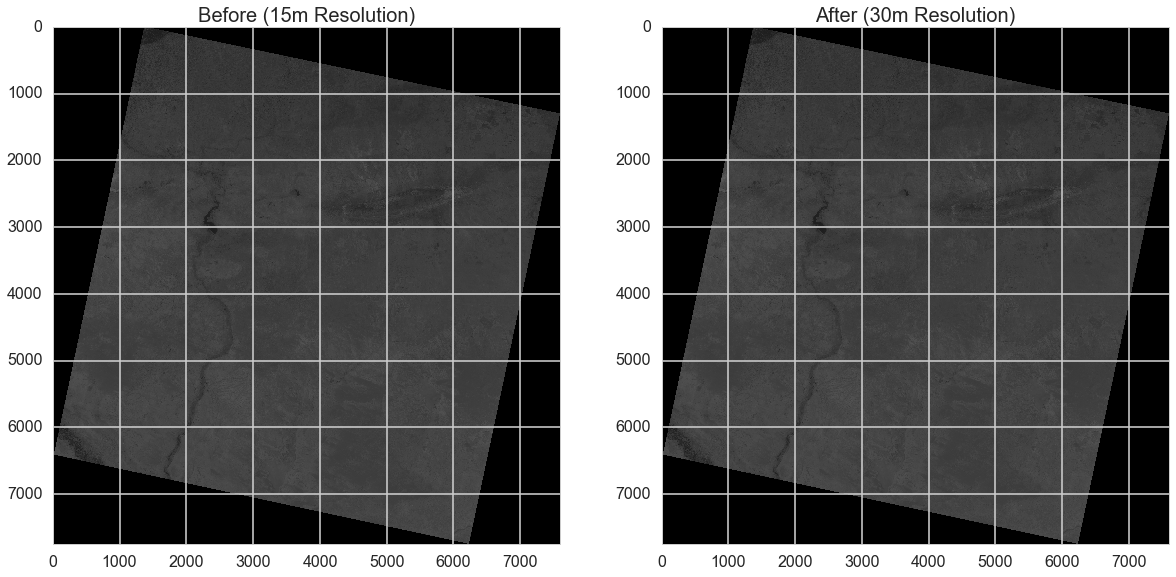

In [20]:
%matplotlib inline
import cv2 

plt.figure(figsize=(20,20))

plt.subplot(121)
plt.title('Before (15m Resolution)', fontsize=20)
img = cv2.imread('LC81710352015234LGN00_B8.TIF')
plt.imshow(img)

plt.subplot(122)
plt.title('After (30m Resolution)',fontsize=20)
img2 = cv2.imread('LC81710352015234LGN00_B8_30m_res.TIF')
plt.imshow(img2)

## 6. Clip Rasters to Data Region 

#### Create Polygon shapefiles to define a rectangular region of known archaeological sites to overlay with pyshp package. This region constitutes our full dataset for building training and testing sets and the shape file will allow us to clip the image to our data region alone.
(Documentation at: https://github.com/GeospatialPython/pyshp)

First, I mapped all the different shapefiles on top of one another in ArcGIS to manually figure out which sites and locations should be included in our dataset given the satellite imagery we had collected. I drew a rectangle around the area of our dataset and collected the vertices of this rectange as a csv file named 'coordinates.csv'. In the image below, the background colored image is the SRTM (elevation data with red and white being high and blue being low), the blue is the Landsat image location, and the transparent is the area covered by Corona imagery.

<img src=Images/full_dataset_map.png/>

In [9]:
#Import CSV containing corners of full dataset region rectangle:
with open('coordinates.csv', 'rb') as f:
    reader = csv.reader(f,quoting=csv.QUOTE_NONNUMERIC) #keeps numbers as floats
    vertices = list(reader)

print list(vertices)

[[634542.34, 4118010.067], [803654.548, 4118010.067], [803654.548, 4039957.914], [634542.34, 4039957.914]]


In [10]:
#Based on coordinates, produce rectangular polygon to clip rasters to same size
import shapefile
w = shapefile.Writer(shapefile.POLYGON)
w.poly(parts=[vertices])
w.field('X')
w.field('Y')
w.record('Full','Polygon')
w.save('Full')

### Clip SRTM to size of shape file using the 'rasterstats' package's zonal_stats function.
The function "zonal_stats" takes a shapefile to clip rasters by, and a raster to be cut, returning the clipped raster if raster_out=True.

In [4]:
srtm_stats = zonal_stats('Full.shp', 'srtm_complete_WGS84_37N.tif', raster_out=True)
srtm = srtm_stats[0]['mini_raster_array']
srtm_affine = srtm_stats[0]['mini_raster_affine']

C:\Users\Jon\Anaconda\lib\site-packages\rasterstats\io.py:281: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


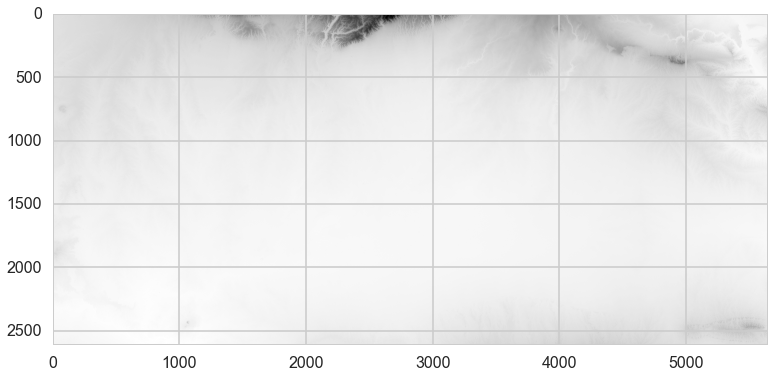

In [5]:
plt.imshow(srtm.data)

### Clip Landsat to size of shape file

In [9]:
clip_images =[]
for i in tif_files:
    lc_stats = zonal_stats('Full.shp', i, raster_out=True)
    lc = lc_stats[0]['mini_raster_array']
    clip_images.append(lc.data)

In [10]:
#We get the size of the clipped images
rows = clip_images[1].shape[0]
cols = clip_images[1].shape[1]

In [11]:
#Create a matrix with the clipped images
bands_matrix = np.zeros((rows*cols,len(clip_images)))
for idx, i in enumerate(clip_images):
    data = i.flatten()
    bands_matrix[:,idx] = data

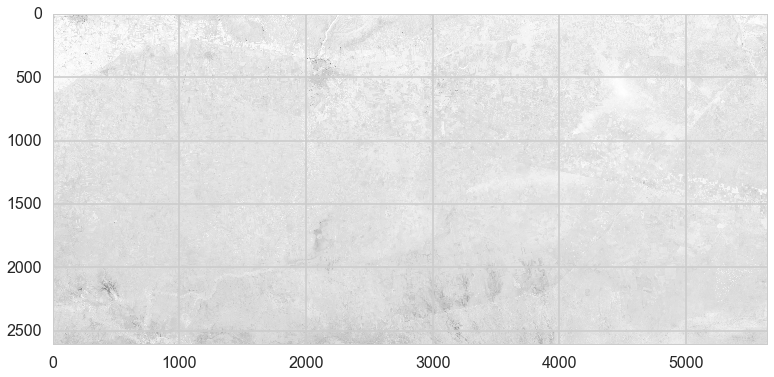

In [12]:
'''
   We then output a raster the size of our data region so that we can use this to turn our response data in kmz line format into
   a raster indicating the extent and area of archaeological site locations by turning values within these kmz lines into 1's and
   the surrounding values into 0s.  The plotted image also provides an example of what our Landsat bands look like.
'''
lc_affine = lc_stats[0]['mini_raster_affine']

nrows,ncols = np.shape(lc.data)
xres = lc_affine[0]
yres = lc_affine[4]
xmin = lc_affine[2]
ymax = lc_affine[5]
geotransform=(xmin,xres,0,ymax,0, yres)

# This output is necessary in order to produce the response raster
output_raster = gdal.GetDriverByName('GTiff').Create('landsat_clip.tif',ncols, nrows, 1,gdal.GDT_Int16)  # Open the file
output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
srs = osr.SpatialReference()                 # Establish its coordinate encoding
srs.ImportFromEPSG(32637)

output_raster.SetProjection(srs.ExportToWkt())   # Exports the coordinate system 
output_raster.GetRasterBand(1).WriteArray(clip_images[0],0,0)   # Writes my array to the raster
output_raster.GetRasterBand(1).FlushCache()
plt.imshow(clip_images[0])

### Clip Corona to size of shape file

In [13]:
corona_stats = zonal_stats('Full.shp', 'corona_merged.tif', raster_out=True)
corona = corona_stats[0]['mini_raster_array']
corona_affine = corona_stats[0]['mini_raster_affine']

###Flatten raster pixels and put into a dictionary, labeled by image type:

In [14]:
#Compare max y/min x coordinates (will impact how many pixels included in the clip)
#Note Corona is slightly higher than the others; we'll need to cut off the first row
#SRTM is slightly shifted to the left, so we will also need to adjust for this column-wise
print "Max Y Coordinate (m):"
print "Corona: ", corona_affine[5]
print "Landsat: ", lc_affine[5]
print "SRTM: ", srtm_affine[5]

print "\nMin X Coordinate (m):"
print "Corona: ", corona_affine[2]
print "Landsat: ", lc_affine[2]
print "SRTM: ", srtm_affine[2]

Max Y Coordinate (m):
Corona:  4118036.57539
Landsat:  4118025.0
SRTM:  4118023.34703

Min X Coordinate (m):
Corona:  634513.793821
Landsat:  634515.0
SRTM:  634539.576994


### Line up Satellite Images (remove top row of Corona) and check to make sure all are same size

In [18]:
sat_images={}
sat_images['SRTM'] = srtm.data.flatten()
sat_images['Corona'] = corona.data[:,1:].flatten()
print len(sat_images['Corona']), len(lc.data.flatten()), len(sat_images['SRTM'])

14675714 14675714 14675714


### All the images are now the same size and are aligned:

In [16]:
print np.shape(srtm.data), np.shape(lc.data), np.shape(corona.data[:,1:])

(2603L, 5638L) (2603L, 5638L) (2603L, 5638L)


### Save All Explanatory variables so that we can pull them up again without performing all of these operations again:
They are save as .npy files because we found any other file format too cumbersome to work with.  CSV's and other text formats took far too long to load and we didn't want to covert them back to images after our hard-fought process of bringing them in as 1 dimensional numpy arrays.

In [19]:
np.save("srtm.npy", sat_images['SRTM'])
np.save("corona.npy", sat_images['Corona'])
np.save("landsat.npy", bands_matrix)

## 7.Principal Component Analysis on the Landsat8 Images


This step is conducted to reduce the size of this enormous data files (and high resolution at 30m) that might make 
classification noisier. PCA is conducted to attempt sparsifying the data.

[ 0.68179633  0.22510633  0.06312043  0.01687006  0.00506829  0.00403214]


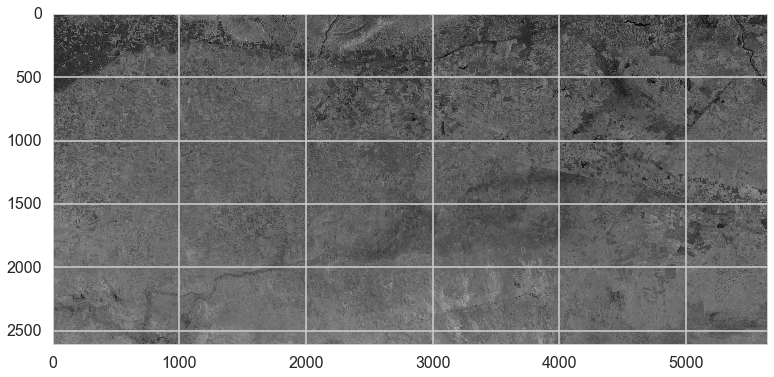

In [20]:
#find the principal components:
pca = PCA(n_components=6)
pca.fit(bands_matrix)

#Determine how well they explain the variance (i.e. how well they do):
print(pca.explained_variance_ratio_) 

#Observe the effect on our Landsat data of only taking the first principal component:
tranformed = pca.transform(bands_matrix)
first_component = tranformed[:,0]
new_image = first_component.reshape(rows, cols)
new_image2= second_component.reshape(rows, cols)
plt.imshow(new_image)

We applied PCA to the Landsat images (to the 11 bands) and we obtained 6 principal components.  We selected the first two because their explained variance ratio was between 0.682 and 0.225, while the explained variance ratio was very small for all the other components.

In [8]:
#Save PCA results to pickle file
pickle.dump(new_image, open('PCA_no_QA.pk', 'wb'))

In [9]:
#also save the Component 2, as this also accounts for a significant amount of variance (.225)
second_component = tranformed[:,1]
new_image2 = second_component.reshape(rows, cols)
pickle.dump(new_image2, open('PCA_QA_2ndComponent.pk', 'wb'))

import tifffile as tiff
tiff.imsave('new_image17134.tif', new_image)

import scipy
scipy.misc.imsave('PCA17134.tif', new_image)

In [11]:
import cv2
cv2.imwrite("PCA.tif", new_image)

from PIL import Image
img = Image.fromarray(new_image)

scipy.misc.imsave('logo.tif', new_image)

## 8. Thresholding to transform the images to binary matrices

Thresholding is the simplest way to segment objects from a background. If that background is relatively uniform, then a global threshold value can be used to binarize the image by pixel-intensity. If there’s large variation in the background intensity, however, adaptive thresholding (may produce better results. The skimage.filters package learn has been used to perform thresholding and both methods have been compared on our SRTM and Landsat images. The images have been binarized using the threshold_otsu, which calculates a global threshold and the threshold_adaptive function, which calculates thresholds in regions of size block_size surrounding each pixel (i.e. local neighborhoods).

### Apply to the different Image types 

### SRTM 

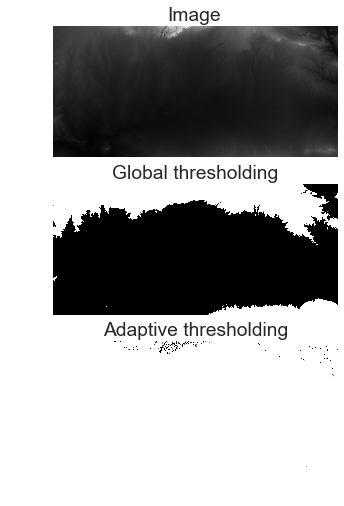

In [25]:
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu, threshold_adaptive

global_thresh = threshold_otsu(srtm.data)
binary_global = srtm.data > global_thresh

block_size = 30
binary_adaptive = threshold_adaptive(srtm.data, block_size, offset=10)

fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
ax0, ax1, ax2 = axes
plt.gray()

ax0.imshow(srtm.data)
ax0.set_title('Image')

ax1.imshow(binary_global)
ax1.set_title('Global thresholding')

ax2.imshow(binary_adaptive)
ax2.set_title('Adaptive thresholding')

for ax in axes:
    ax.axis('off')

plt.show()

In [26]:
srtm_treshold=binary_global.flatten()

#### Therefore, we use global tresholding as we can see that adaptive tresholding does not communicate the information contained in the image.  Adaptive thresholding does not appear to do a very good job at parsing our image's characteristic features.

## LandSat Images

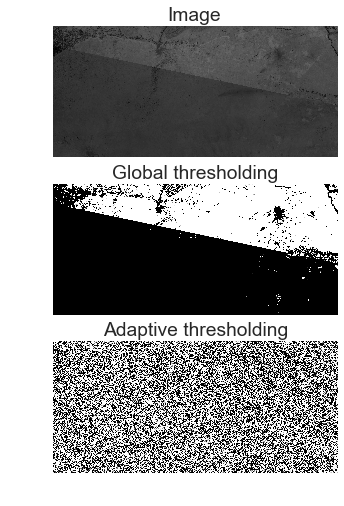

In [32]:
# First Component of PCA
global_thresh = threshold_otsu(new_image)
binary_global =  new_image > global_thresh

block_size = 30
binary_adaptive = threshold_adaptive(new_image, block_size, offset=10)

fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
ax0, ax1, ax2 = axes
plt.gray()

ax0.imshow(new_image)
ax0.set_title('Image')

ax1.imshow(binary_global)
ax1.set_title('Global thresholding')

ax2.imshow(binary_adaptive)
ax2.set_title('Adaptive thresholding')

for ax in axes:
    ax.axis('off')

plt.show()

In [27]:
PCA1_treshold=binary_global.flatten()

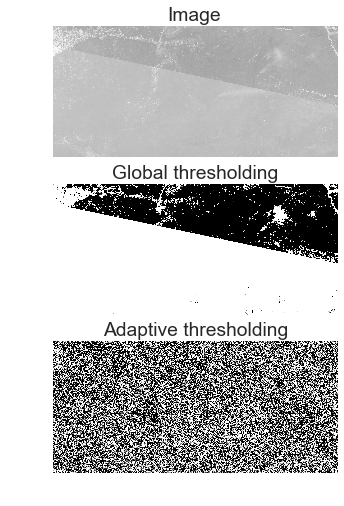

In [28]:
# Second Component of PCA
global_thresh = threshold_otsu(new_image2)
binary_global =  new_image2 > global_thresh

block_size = 30
binary_adaptive = threshold_adaptive(new_image2, block_size, offset=10)

fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
ax0, ax1, ax2 = axes
plt.gray()

ax0.imshow(new_image2)
ax0.set_title('Image')

ax1.imshow(binary_global)
ax1.set_title('Global thresholding')

ax2.imshow(binary_adaptive)
ax2.set_title('Adaptive thresholding')

for ax in axes:
    ax.axis('off')

plt.show()

In [29]:
PCA2_treshold=binary_global.flatten()

#### Similarly, we use try using global tresholding for each Landsat image (independent of PCA) as we can see that adaptive tresholding does not communicate the information contained in each image.  If the PCA turns out not to be a good option, we at least can test to see if global thresholding each individual image will help us.

In [33]:
m=len(srtm_treshold)
n=len(bands_matrix[2])
bands_matrix2=np.zeros((m,n))
                       
for i in xrange(len(bands_matrix[2])):
    img3=bands_matrix[:,i]
    img3=img3.reshape((2603,5638))

    global_thresh = threshold_otsu(img3)
    binary_global = img3 > global_thresh

    bands_matrix2[:,i]=binary_global.flatten()

### Corona Images

In [19]:
img4=corona.data
global_thresh = threshold_otsu(img4)
binary_global2 = img4 > global_thresh
#Corona is again too tall by one row, so we eliminate this row:
corona_treshold1=binary_global2[:,1:].flatten()
corona_treshold2=binary_global.flatten()

### Put all the tresholded image data (all image types) in a dataframe and save it  

In [40]:
sites = np.load('sites.npy')
sites = sites.flatten()

columns = ['Landsat PCA 1st','Landsat PCA 2nd', 'corona','srtm','sites']
df2 = pd.DataFrame(columns=columns)
df2['corona']=np.asarray(corona_treshold2)
df2['srtm']=np.asarray(srtm_treshold)
df2['sites']= sites
df2['Landsat PCA 2nd']=PCA1_treshold
df2['Landsat PCA 1st']=PCA2_treshold

In [42]:
threshold_PCA=df2
threshold_PCA.head(10)

,Landsat PCA 1st,Landsat PCA 2nd,corona,srtm,sites
0,False,True,False,True,False
1,False,True,False,True,False
2,False,True,False,True,False
3,False,True,False,True,False
4,False,True,False,True,False
5,False,True,False,True,False
6,True,True,True,True,False
7,True,True,True,True,False
8,True,True,True,True,False
9,True,True,True,True,False


In [43]:
threshold_PCA.to_pickle('Treshold_PCA.pk') 

In [54]:
#'sites.npy' numpy array comes from Part2 Response Variable Wrangling Ipython notebook, (but preloaded in current directory):
sites = np.load('sites.npy')
sites = sites.flatten()

columns = ['B1','B10','B11','B2','B3','B4','B5','B6','B7','B8','B9', 'corona','srtm','sites']
df = pd.DataFrame(columns=columns)
df['corona']=np.asarray(corona_treshold1)
df['srtm']=np.asarray(srtm_treshold)
df['sites']= sites
df['B1'] = bands_matrix2[:,0]
df['B10'] = bands_matrix2[:,1]
df['B11'] = bands_matrix2[:,2]
df['B2'] = bands_matrix2[:,3]
df['B3'] = bands_matrix2[:,4]
df['B4'] = bands_matrix2[:,5]
df['B5'] = bands_matrix2[:,6]
df['B6'] = bands_matrix2[:,7]
df['B7'] = bands_matrix2[:,8]
df['B8'] = bands_matrix2[:,9]
df['B9'] = bands_matrix2[:,10]

treshold=df
treshold.head(10)

,B1,B10,B11,B2,B3,B4,B5,B6,B7,B8,B9,corona,srtm,sites
0,0,1,1,0,0,0,0,0,0,0,0,False,False,False
1,0,1,1,0,0,0,0,0,0,0,0,False,False,False
2,0,1,1,0,0,0,0,0,0,0,0,False,False,False
3,0,1,1,0,0,0,0,0,0,0,0,False,False,False
4,0,1,1,0,0,0,0,0,0,0,0,True,False,False
5,0,1,1,0,0,0,0,0,0,0,0,False,False,False
6,0,0,1,0,0,0,0,0,0,0,0,True,False,False
7,0,0,1,0,0,0,0,0,0,0,0,False,False,False
8,0,0,0,0,0,0,0,0,0,0,0,False,False,False
9,0,0,0,0,0,0,0,0,0,0,0,False,False,False


In [55]:
treshold.to_pickle('Treshold.pk') 